In [27]:
import csv
from sys import argv
import os.path
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

In [7]:
pd.set_option("display.max_rows", 500)

In [2]:
reviews_file_path = "./reviews_by_course.csv"
df = pd.read_csv(reviews_file_path, header=0, error_bad_lines=False)
df = df.dropna()
df.tail()

,CourseId,Review,Label
140315,zika,Trendy topic with talks from expertises in the...,4
140316,zika,"Wonderful! Simple and clear language, good ins...",5
140317,zika,an interesting and fun course. thanks. dr quincy,5
140318,zika,"very broad perspective, up to date information...",4
140319,zika,An informative course on the social and financ...,4


In [3]:
df.shape

(140317, 3)

In [8]:
df['CourseId'].value_counts()

machine-learning           8570
learning-how-to-learn      7090
python                     5906
python-data                2372
python-network-data        1844
                           ... 
discrete-mathematics-ch       1
formadores-ciudadania         1
bim-yingyong                  1
historia-reglas-futbol        1
ict-primary-education         1
Name: CourseId, Length: 1835, dtype: int64

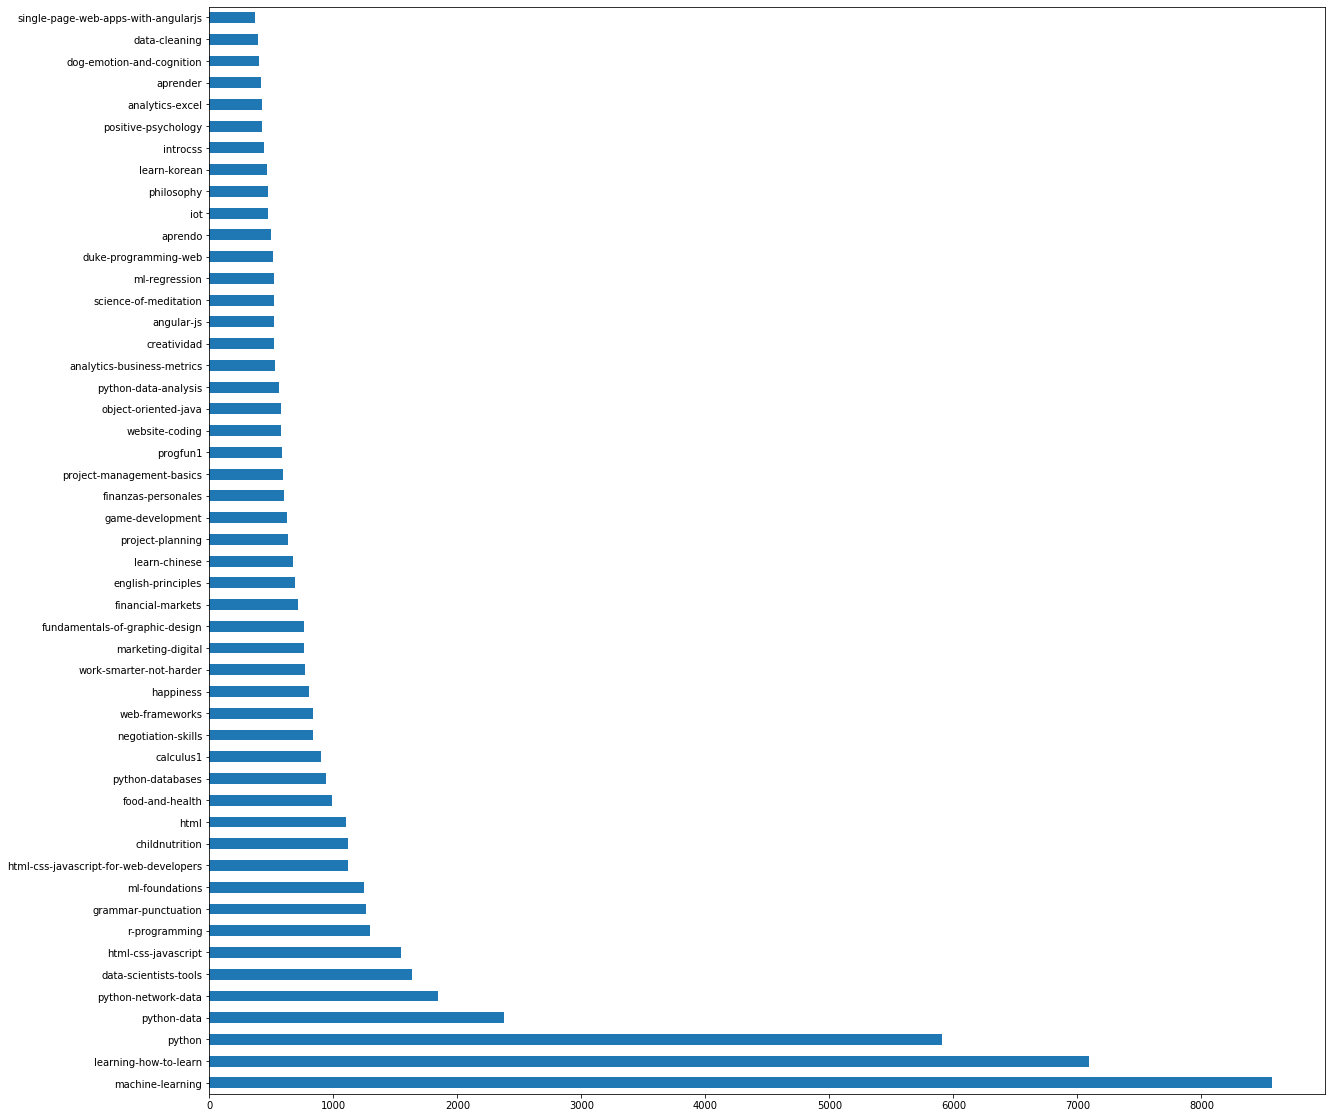

In [80]:
## Group Courses by review count
df['CourseId'].value_counts()[:50].plot(kind='barh', figsize=(20, 20))

In [13]:
## Filter Reviews For course Machine Learning
machine_learning_df = df.loc[df['CourseId'] == 'machine-learning']
machine_learning_df.head()

,CourseId,Review,Label
73134,machine-learning,A great course given with passion and clarity....,5
73135,machine-learning,私はソフトエンジニアですが、これまで機械学習という課題に取り組んだことがありませんでした。こ...,5
73136,machine-learning,excellent,5
73137,machine-learning,Very good course! The vectorisation can be a b...,5
73138,machine-learning,"Great course, great teacher, great level of de...",5


In [14]:
## No of reviews for machine learning course
machine_learning_df.shape

(8570, 3)

In [15]:
## Filter only Reviews With English alphanumeric chars
machine_learning_df = machine_learning_df[machine_learning_df['Review'].str.contains('[A-Za-z0-9 ]', na=False)]
machine_learning_df.head()

,CourseId,Review,Label
73134,machine-learning,A great course given with passion and clarity....,5
73136,machine-learning,excellent,5
73137,machine-learning,Very good course! The vectorisation can be a b...,5
73138,machine-learning,"Great course, great teacher, great level of de...",5
73139,machine-learning,It was a great course .I learned most importan...,5


In [16]:
# Adding Sentiment Score For Review Using textblob (https://textblob.readthedocs.io/en/dev/)
from textblob import TextBlob
machine_learning_df['sentiment_score'] = machine_learning_df['Review'].map(lambda text:TextBlob(text).sentiment.polarity)
machine_learning_df['review_len'] = machine_learning_df['Review'].astype(str).apply(len)

In [17]:
machine_learning_df.head()

,CourseId,Review,Label,sentiment_score,review_len
73134,machine-learning,A great course given with passion and clarity....,5,0.616667,268
73136,machine-learning,excellent,5,1.000000,9
73137,machine-learning,Very good course! The vectorisation can be a b...,5,0.185256,96
73138,machine-learning,"Great course, great teacher, great level of de...",5,0.800000,59
73139,machine-learning,It was a great course .I learned most importan...,5,0.533333,204


In [18]:
## Sample Reviews With Positive Sentiment Score
machine_learning_df.loc[machine_learning_df.sentiment_score == 1, ['Review']].sample(5)

,Review
74658,Very good course for ML beginner!
74330,very good job!
79377,Great course!
79826,Awesome!
75311,Excellent! 脑洞大开


In [20]:
## Sample Reviews With Negative Sentiment Score
machine_learning_df.nsmallest(10, 'sentiment_score')

,CourseId,Review,Label,sentiment_score,review_len
80273,machine-learning,Insane knowledge in this course for anyone who...,5,-1.000000,117
79579,machine-learning,"Genial, aprendo mucho de sus clases, en alguna...",5,-0.800000,138
80589,machine-learning,This is a very difficult course,5,-0.650000,31
78912,machine-learning,Certificate is expensive!,2,-0.625000,25
74311,machine-learning,Excelente curso. Práctico y ameno. Muy recomen...,5,-0.600000,101
76503,machine-learning,"Wonderfull Course, I learned a lot about artif...",5,-0.600000,64
79283,machine-learning,excelente cuso en el cual se imparte a grandes...,5,-0.600000,221
81249,machine-learning,complex concepts simplified...!!!,5,-0.585938,33
81457,machine-learning,unfortunately nothing is being done to fix err...,5,-0.575000,87
77885,machine-learning,"Outdated material, nightmare to submit assignm...",1,-0.550000,78


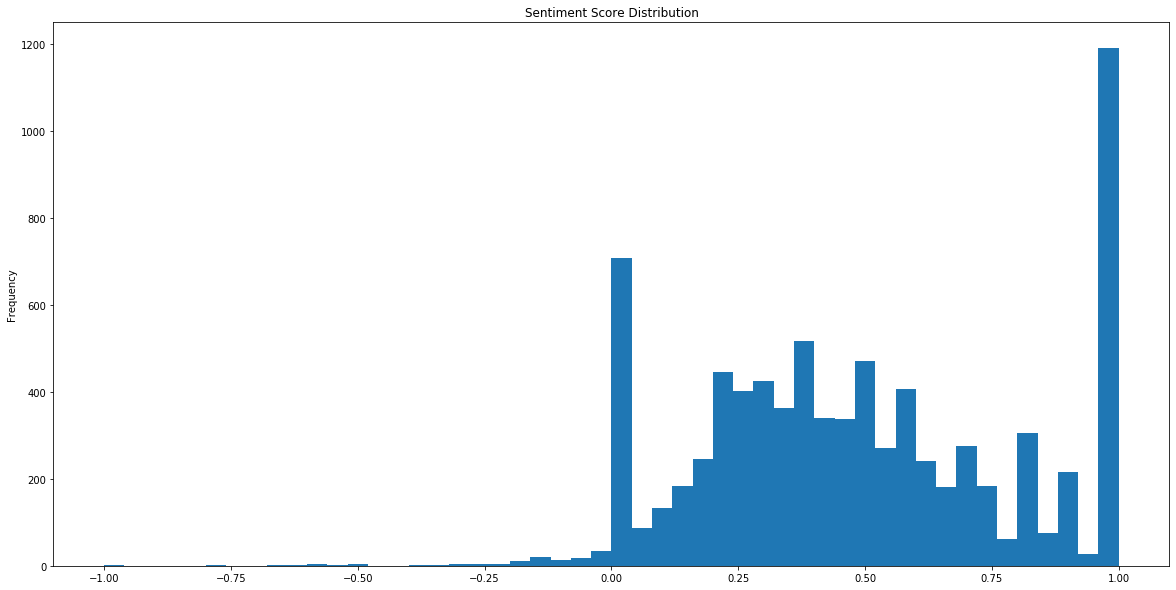

In [22]:
## Plotting Sentiment Scores Distribution for Reviews
machine_learning_df['sentiment_score'].plot(
    kind='hist',
    bins=50,
    x='sentiment_score',
    y='count',
    title='Sentiment Score Distribution',
    figsize=(20, 10))

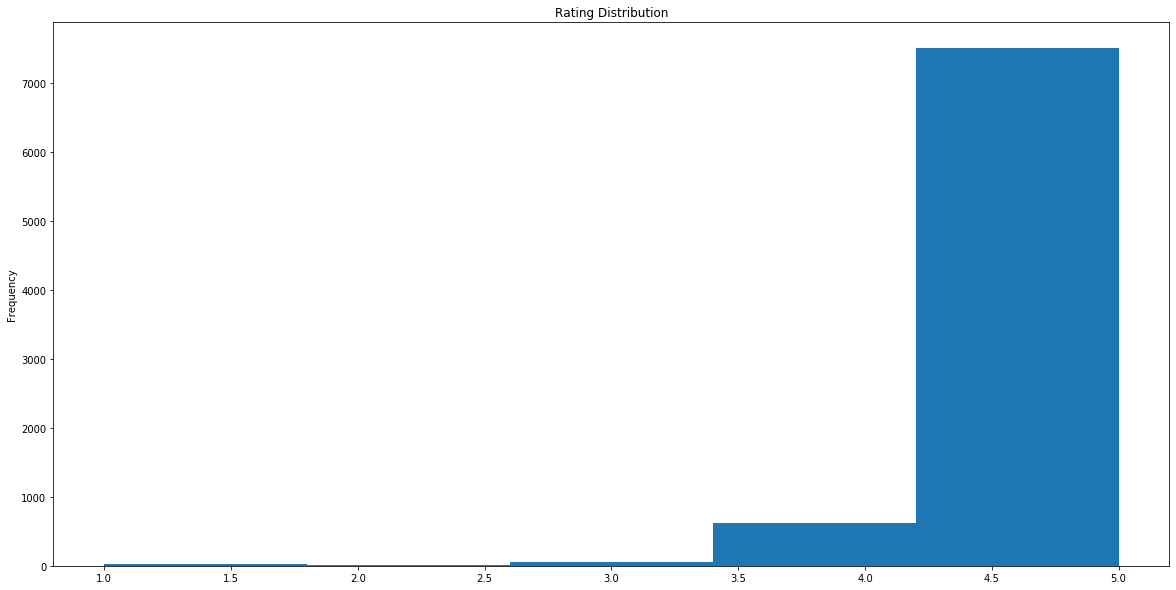

In [24]:
## Plotting Ratings Distribution for Reviews
machine_learning_df['Label'].plot(
    kind='hist',
    bins=5,
    x='Label',
    y='count',
    title='Rating Distribution',
    figsize=(20, 10))

In [25]:
## Filtering Positive and negative reviews
negative_reviews = machine_learning_df[machine_learning_df['sentiment_score'] < 0]
positive_reviews = machine_learning_df[machine_learning_df['sentiment_score'] > 0]
neutral_reviews = machine_learning_df[machine_learning_df['sentiment_score'] == 0]

In [81]:
## Use CounVectorizer to analyze top n grams of the reviews
def get_top_k_ngrams(corpus, k=1, n=None):
    vec = CountVectorizer(ngram_range=(k, k),stop_words = 'english')
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_words_graph(common_words):
    df1 = pd.DataFrame(common_words, columns = ['Review' , 'count'])
    df2 = df1.groupby('Review').sum()['count'].sort_values(ascending=True).plot(
        kind='barh', y='Count', x='Word', figsize=(20, 10))

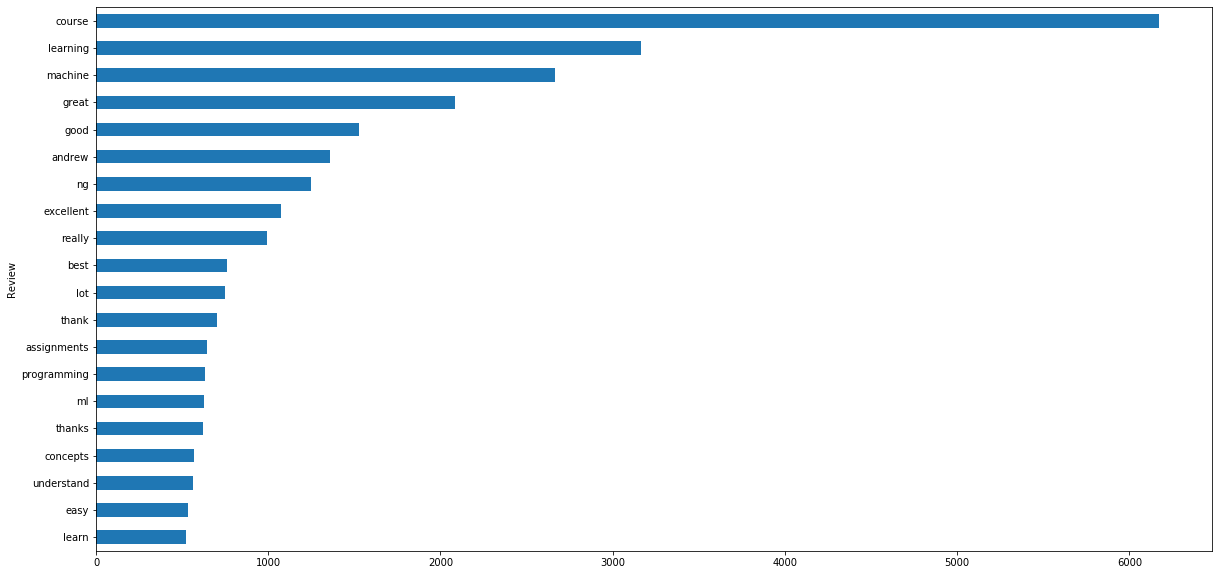

In [73]:
## Analyzing Positive Reviews

### 1 gram Words
common_words = get_top_k_ngrams(positive_reviews['Review'], 1, 20)
plot_words_graph(common_words)

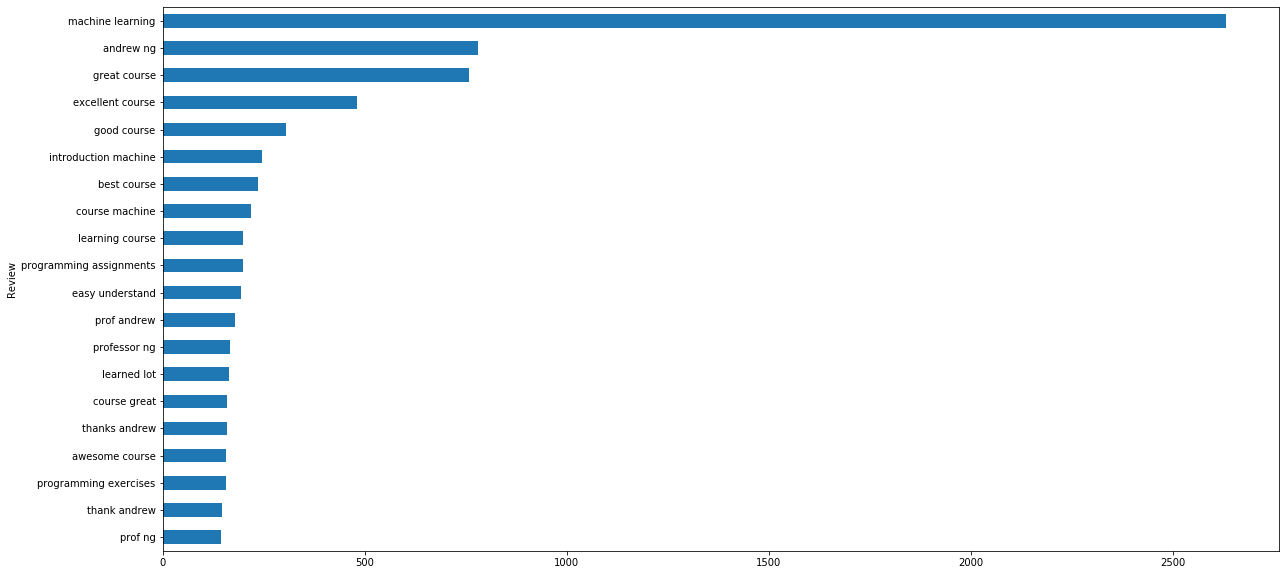

In [74]:
### Bi-gram Words
common_words = get_top_k_ngrams(positive_reviews['Review'], 2, 20)
plot_words_graph(common_words)

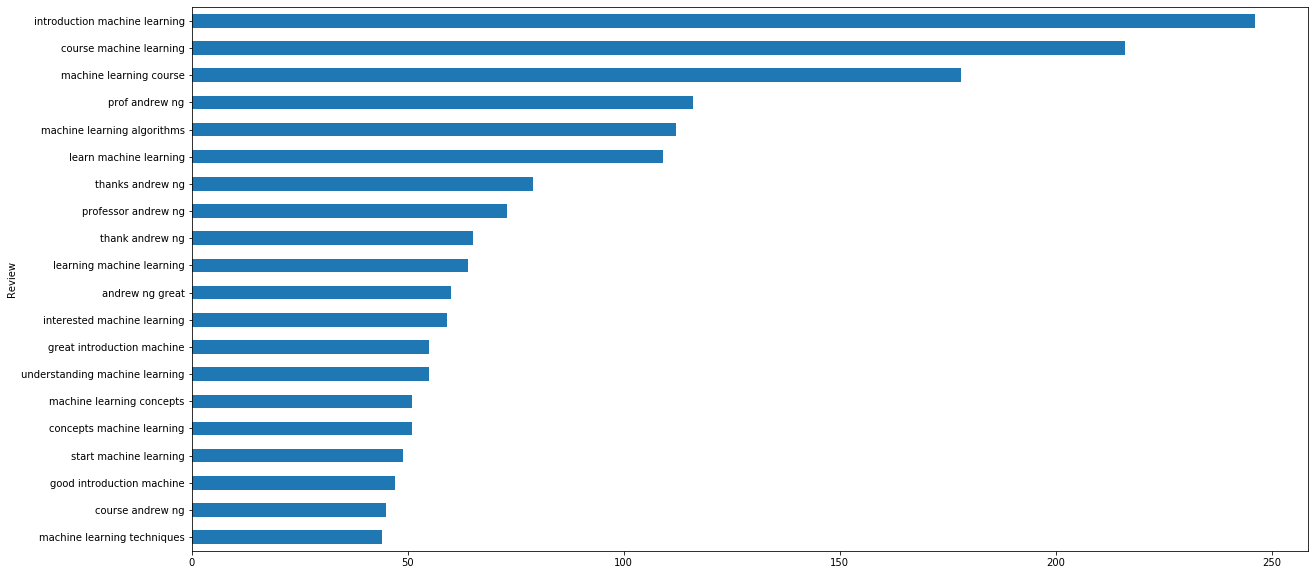

In [75]:
### Tri-gram Words
common_words = get_top_k_ngrams(positive_reviews['Review'], 3, 20)
plot_words_graph(common_words)

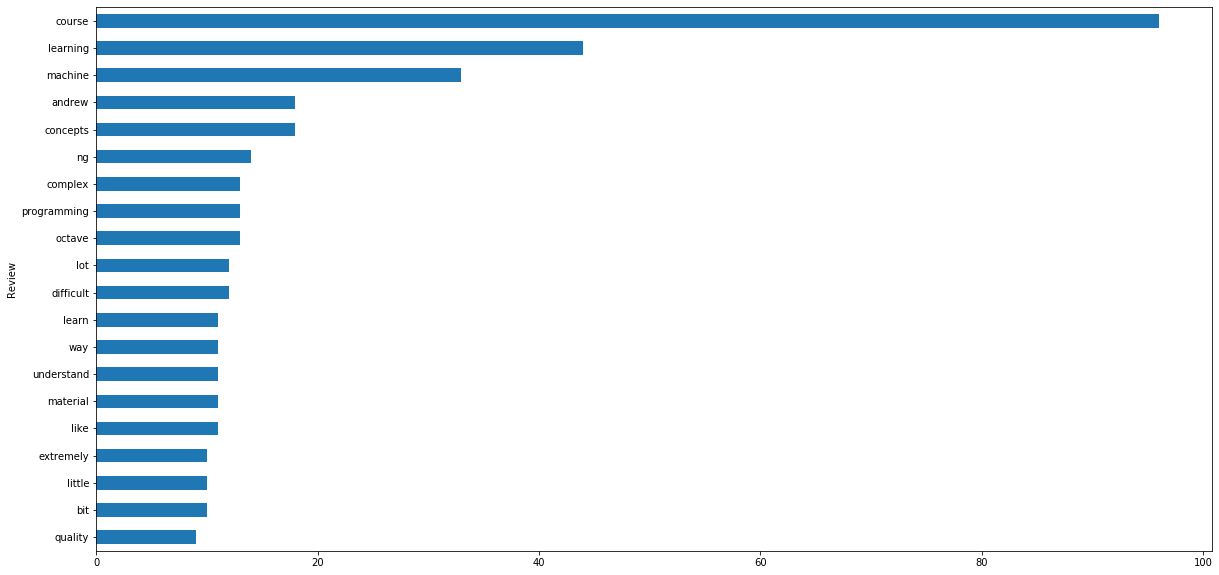

In [76]:
## Analyzing Negative Reviews
### 1 gram Words
common_words = get_top_k_ngrams(negative_reviews['Review'], n=20)
plot_words_graph(common_words)

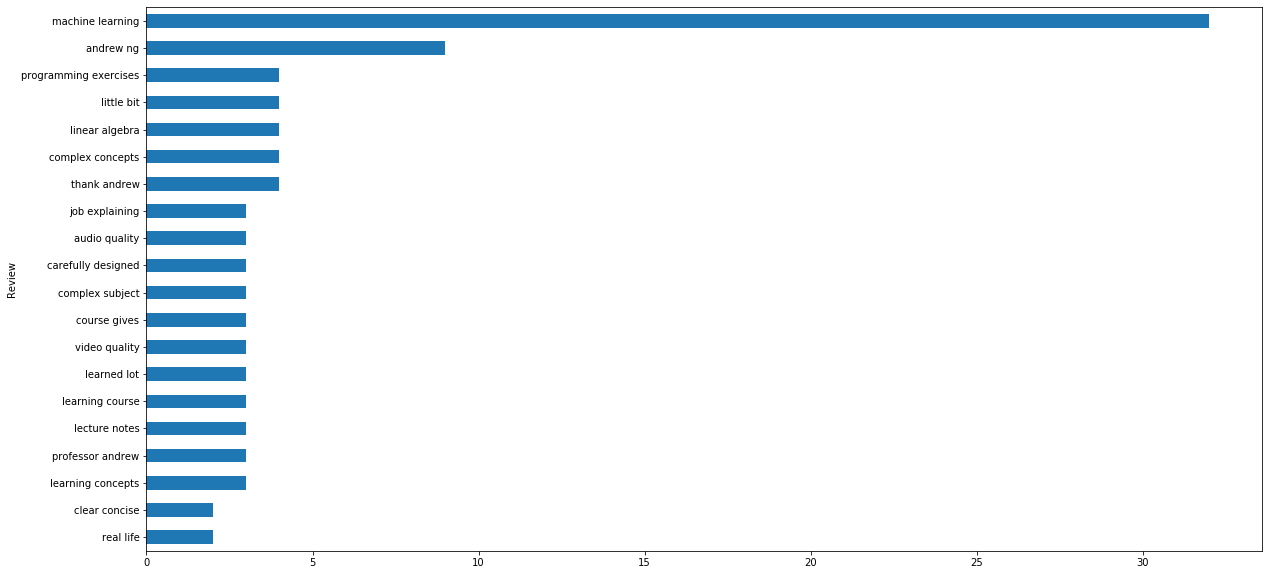

In [77]:
### Bi-gram Words
common_words = get_top_k_ngrams(negative_reviews['Review'], 2, 20)
plot_words_graph(common_words)

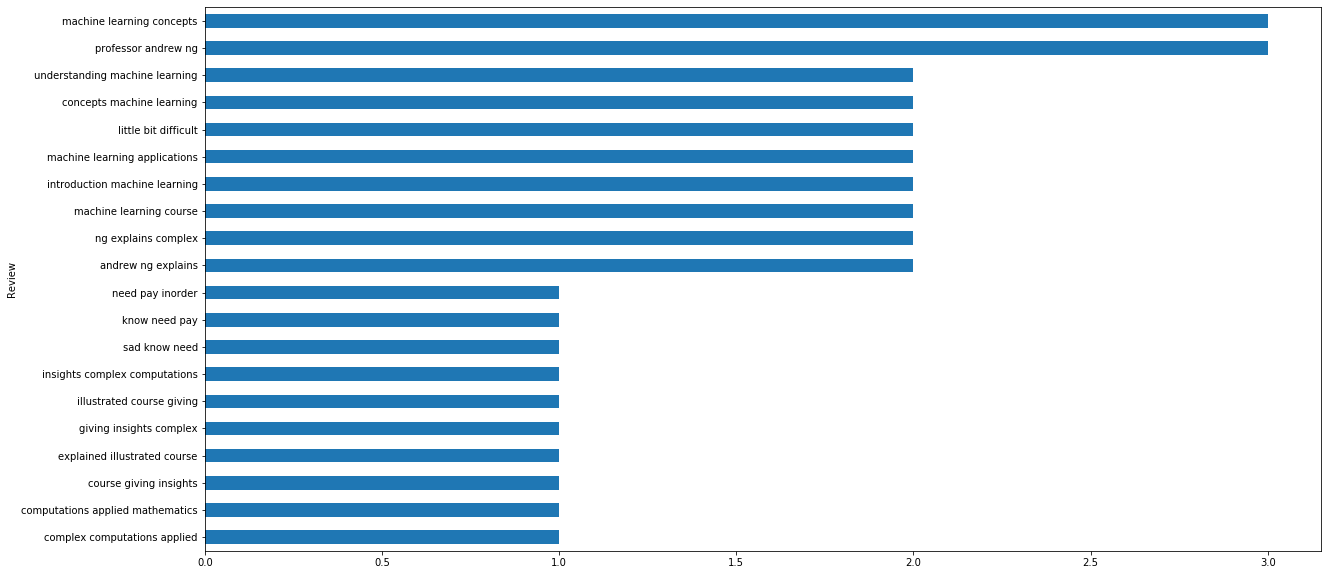

In [78]:
### Tri-gram Words
common_words = get_top_k_ngrams(negative_reviews['Review'], 3, 20)
plot_words_graph(common_words)